<a href="https://colab.research.google.com/github/ykkimhgu/DLIP-src/blob/main/Tutorial_Pytorch/Assignment_PyTorch_T3_3_Transfer_Learning_using_Pre_trained_Models_(classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DLIP Tutorial - PyTorch**
# Transfer Learning using Pre-trained Models (Classification) - Assignment

Y.-K. Kim
(updated 2022. 5. 10) 

===================

Create a CNN model 'EfficientNet(efficientnet_b7)' and Train with Custom Dataset

## For CoLab Usage:

1. Download this notebook
2. Then, open in Colab

# Environment Setup

Download Python modules and image data. 
- [download modules](https://drive.google.com/file/d/1hjrWkcvBTiI-5yGtWPvsYVdaE7YLNWDo/view?usp=sharing)
- [download dataset(cat/dog)](https://drive.google.com/file/d/1KYOAxXDIqp_hhE97WWQ_C8TeGFHWkxqG/view?usp=sharingg)


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import random_split, Subset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# from set_parameter_requires_grad import set_parameter_requires_grad
from initialize_model import initialize_model
from my_train import train
from my_test import test
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'Device name: {torch.cuda.get_device_name(0)}') 



Using cuda device
Device name: NVIDIA GeForce RTX 4080 Laptop GPU


# MODEL

Basically, the classification models provided by torchvision are trained on ImageNet and consist of 1000 output layers.

However, in the model for fine-tuning with other datasets, the number of output layers should be different depending on the class.

Here, we use the initialize_model() function provided in the [pytorch tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) to change the output stage of the model.

initialize_model() is a function that helps to initialize the fine-tuning of some models.

If the model is not in the function, the output layer information can be known by printing the model with the print() function.

In [48]:
# model = models.efficientnet_b7(pretrained=True)
# print(model)

In [49]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception*]
model_name = "efficientnet_b7"

# Number of classes in the dataset
num_classes = 2

feature_extract = True   # True: only update the reshaped layer params, False: finetune the whole model, 

####################################################################
### add your code for 'efficientnet_b7' in 'initialize_model.py' ###
####################################################################

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)  
model_ft = model_ft.to(device)

from torchsummary import summary
summary(model_ft, (3,input_size,input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,728
       BatchNorm2d-2         [-1, 64, 300, 300]             128
              SiLU-3         [-1, 64, 300, 300]               0
            Conv2d-4         [-1, 64, 300, 300]             576
       BatchNorm2d-5         [-1, 64, 300, 300]             128
              SiLU-6         [-1, 64, 300, 300]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]           1,040
              SiLU-9             [-1, 16, 1, 1]               0
           Conv2d-10             [-1, 64, 1, 1]           1,088
          Sigmoid-11             [-1, 64, 1, 1]               0
SqueezeExcitation-12         [-1, 64, 300, 300]               0
           Conv2d-13         [-1, 32, 300, 300]           2,048
      BatchNorm2d-14         [-1, 32, 3

# Prepare Datasets: kaggle cats and dogs

**TO DO**

download the kaggle cats and dogs dataset: [download link](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

In [50]:
### ADD YOUR CODE HERE
import shutil
import os
# shutil.unpack_archive("data/hymenoptera_data.zip", "data")

The images in the prepared dataset have different sizes. In order to be used as a learning model, the following process is required. (refer to part2)

- Assign the images in the folder to training/test data for learning
- Same pre-processing as ImageNet data for input of learning model

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms 
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# 2) Corrupted image removal function
def remove_corrupted_images(root_dir):
    for cls in os.listdir(root_dir):
        cls_folder = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_folder):
            continue
        for fname in os.listdir(cls_folder):
            fpath = os.path.join(cls_folder, fname)
            try:
                img = Image.open(fpath)
                img.verify()
            except Exception:
                print("Removing corrupted file:", fpath)
                os.remove(fpath)
#   to the ImageFolder structure
data_dir = "./data/kagglecatsanddogs/PetImages"
remove_corrupted_images(data_dir)
# Data augmentation and normalization for training
# Just normalization for validation

transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )
    ]),
}

full_ds = torchvision.datasets.ImageFolder(
    data_dir,
    transform=transform['train']  # 일단 train용 전처리로 읽어 두고
)

total_size = len(full_ds)
train_size = int(0.8 * total_size)
test_size   = total_size - train_size

training_data, test_data = random_split(
    full_ds,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

test_data.dataset.transform = transform['val']

print("Initializing Datasets and Dataloaders...")

classes = ['Cat', 'Dog']
print(f"train dataset length = {len(training_data)}")
print(f"test  dataset length = {len(test_data)}")

Removing corrupted file: ./data/kagglecatsanddogs/PetImages\Cat\666.jpg
Initializing Datasets and Dataloaders...
train dataset length = 19998
test  dataset length = 5000


Use DataLoader to make dataset iterable.

In [52]:
batch_size = 32

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data,   batch_size=batch_size, shuffle=False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 600, 600]) torch.int64
Shape of y: torch.Size([32]) torch.int64


# Optimization Setup

### Optmizer function 
 Gradient descent is the common optimisation strategy used in neural networks. Many of the variants and advanced optimisation functions now are available, 
  
- Stochastic Gradient Descent, Adagrade, Adam, etc

### Loss function

- Linear regression->Mean Squared Error
- Classification->Cross entropy

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9,weight_decay=5e-4)

# Train and Test the model

In [54]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_ft, loss_fn, optimizer, device, 15)
    test(test_dataloader, model_ft, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 0.714535  [    0/19998]
loss: 0.598609  [  480/19998]
loss: 0.509450  [  960/19998]
loss: 0.484613  [ 1440/19998]
loss: 0.337726  [ 1920/19998]
loss: 0.339442  [ 2400/19998]
loss: 0.345078  [ 2880/19998]
loss: 0.297608  [ 3360/19998]
loss: 0.187228  [ 3840/19998]
loss: 0.268048  [ 4320/19998]
loss: 0.205158  [ 4800/19998]
loss: 0.216840  [ 5280/19998]
loss: 0.237740  [ 5760/19998]
loss: 0.187741  [ 6240/19998]
loss: 0.222543  [ 6720/19998]
loss: 0.184007  [ 7200/19998]
loss: 0.158782  [ 7680/19998]
loss: 0.218404  [ 8160/19998]
loss: 0.226875  [ 8640/19998]
loss: 0.151037  [ 9120/19998]
loss: 0.193625  [ 9600/19998]
loss: 0.190874  [10080/19998]
loss: 0.365450  [10560/19998]
loss: 0.202818  [11040/19998]
loss: 0.211050  [11520/19998]
loss: 0.158018  [12000/19998]
loss: 0.242837  [12480/19998]
loss: 0.125894  [12960/19998]
loss: 0.133684  [13440/19998]
loss: 0.104005  [13920/19998]
loss: 0.200368  [14400/19998]
loss: 0.137062  [14880/19998]


# Visualize test results

Select random test images and evaluate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018410504..0.8755779].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018410504..0.9809897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018410504..0.9380442].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014574587..1.0473601].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018410504..1.0356476].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10196078..1.0473601].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

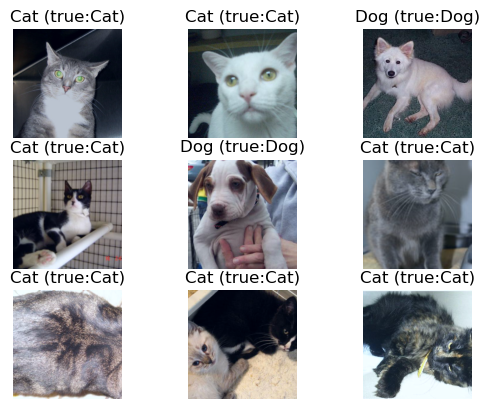

In [55]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    pred = model_ft(images)
    _, predicted = torch.max(pred.data, 1);

figure = plt.figure()
num_of_images = min(batch_size, 9)

for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.title(f"{classes[predicted[index].item()]} (true:{classes[labels[index]]})")
    plt.imshow(np.transpose((images[index] * 0.224  + 0.456).cpu().numpy().squeeze(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)

Plot heatmap (confusion matrix)

      Cat   Dog
Cat  2461    43
Dog    24  2472


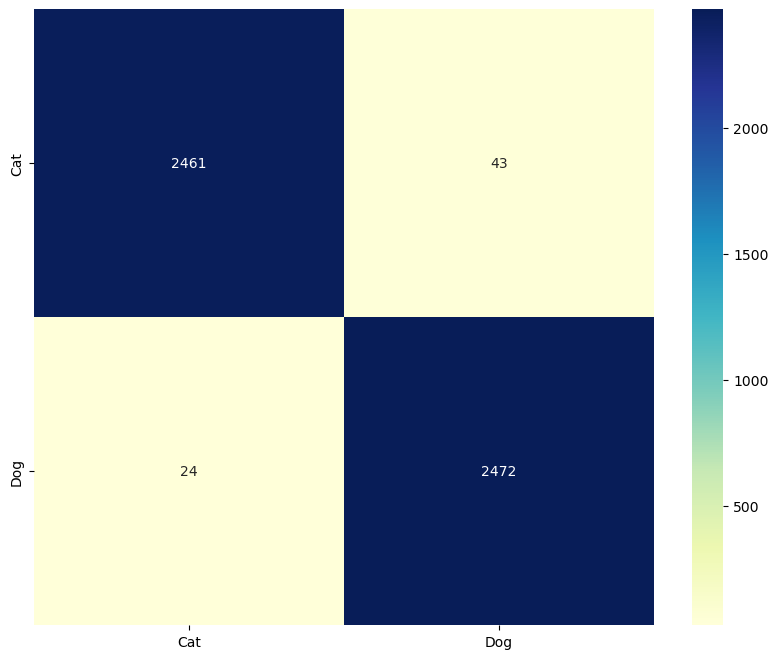

In [56]:
# Get some random test  images // BatchSize at a time
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)

for images, labels in test_dataloader:
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label, predicted_label] += 1
print(heatmap)
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

# Saving Models
* save the structure of this class together with the model

In [57]:
torch.save(model_ft, f"./models/{model_name}_ft(kagglecatsanddogs).pth")